In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn

from tqdm.notebook import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print(device)

torch.manual_seed(0)
np.random.seed(0)

cpu


In [2]:
hoop_location = torch.tensor([0, 0.8])

o_player_idxs = torch.arange(5)
d_player_idxs = torch.arange(5, 10)
ball_idxs = torch.tensor([10])

num_game_steps = 50


def random_initial_game_state(batch_size, only_game_state=True):
    opls = torch.rand(batch_size, len(o_player_idxs), 2)*2 - 1
    dpls = torch.rand(batch_size, len(d_player_idxs), 2)*2 - 1
    bls = torch.rand(batch_size, len(ball_idxs), 2)*2 - 1
    
    init_game_state = torch.cat((opls, dpls, bls), dim=1)
    
    if only_game_state:
        return init_game_state
    else:
        return init_game_state, opls, dpls, bls

# Game Visualization

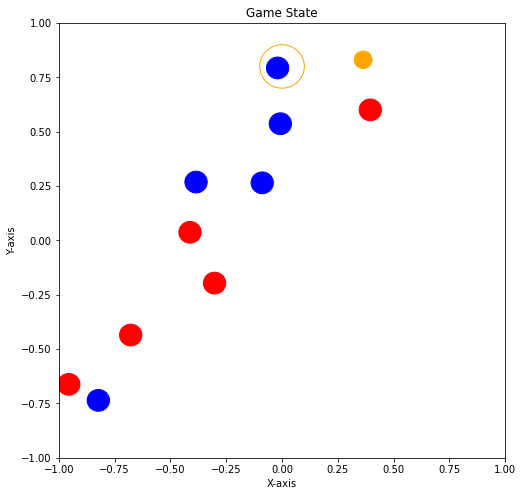

In [3]:
def show_game_state(game_state, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8)) # note we must use plt.subplots, not plt.subplot
    # (or if you have an existing figure)
#     fig = plt.gcf()
#     ax = fig.gca()
    
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    
    for o_player in o_player_idxs.numpy():
        x, y = game_state[o_player]
        circle = plt.Circle((x, y), radius = 0.05, color='b')
        ax.add_artist(circle)
    for d_player in d_player_idxs.numpy():
        x, y = game_state[d_player]
        circle = plt.Circle((x, y), radius = 0.05, color='r')
        ax.add_artist(circle)
    for ball in ball_idxs.numpy():
        x, y = game_state[ball]
        circle = plt.Circle((x, y), radius = 0.04, color='orange')
        ax.add_artist(circle)
    
    ax.add_artist(plt.Circle(hoop_location.numpy(), radius=0.1, color='orange', fill=False))
    
    ax.set_title('Game State')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
#     circle2 = plt.Circle((0.5, 0.5), 0.2, color='blue')
#     circle3 = plt.Circle((-1, 1), 0.2, color='g', clip_on=False)
    return ax
#     return fig

game_state = torch.rand(11, 2) * 2 - 1
show_game_state(game_state)
plt.show()

# Model Definitions

In [4]:
def get_dense_layers(num_features):
    acts = [torch.nn.LeakyReLU() for num_out in num_features[1:-1]]
    acts.append(torch.nn.Identity())
    layers = []
    for num_in, num_out, act in zip(num_features, num_features[1:], acts):
        layers.extend((torch.nn.Linear(num_in, num_out), act))
    return torch.nn.Sequential(*layers)

class OffenseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = get_dense_layers([11*2, 100, 100, 6*2])
    def forward(self, X):
        X = X.view(-1, 11*2)
        X = self.main(X)
        X = torch.tanh(X)
        X = X.view(-1, 6, 2)
        return X
    
class DefenseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = get_dense_layers([11*2, 100, 100, 5*2])
    def forward(self, X):
        X = X.view(-1, 11*2)
        X = self.main(X)
        X = 0.1 * torch.tanh(X)
        X = X.view(-1, 5, 2)
        return X
    
o_model = OffenseModel()
d_model = DefenseModel()


# Optimization

In [5]:
def loss_function(all_game_states):
    loss = 0.0
    for game_state in all_game_states:
#         ball = game_state[:, ball_idxs] # b, 1, 2
        ls = game_state[:, torch.cat((o_player_idxs, d_player_idxs, ball_idxs)), :]
    
        center = torch.tensor([0,0])[None, None, :]
        
        dists = ls - center
        dists = dists.norm(dim=-1)
        loss += dists.mean()
#         loss = loss + dists.min(dim=-1).values.mean()
        
    return loss

In [6]:
def run_simulation(o_model, d_model, init_game_state, with_grad=False, pbar=None):
    all_game_states = [init_game_state]
    
    current_game_state = init_game_state
    with torch.set_grad_enabled(with_grad):
        
        if pbar is not None:
            pbar.reset(total=num_game_steps)
        for game_step in range(num_game_steps):
            o_move = o_model(current_game_state)
            d_move = d_model(current_game_state)

            current_game_state = current_game_state.clone()
            current_game_state[:, torch.cat((o_player_idxs, ball_idxs)), :] += o_move
            current_game_state[:, d_player_idxs, :] += d_move
            current_game_state = current_game_state.clamp(-1, 1)

            all_game_states.append(current_game_state)
            if pbar is not None:
                pbar.update()
    return all_game_states
        

Loss:  51.4874153137207


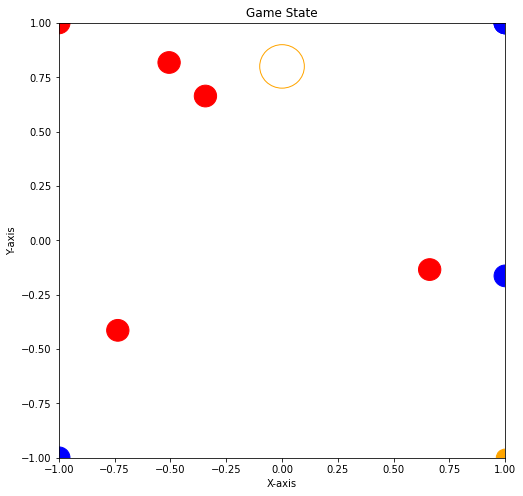

In [7]:
init_game_state = random_initial_game_state(batch_size=1)
all_game_states = run_simulation(o_model, d_model, init_game_state)

print('Loss: ', loss_function(all_game_states).item())
show_game_state(all_game_states[-1][0])
plt.show()

In [8]:
batch_size = 19

o_opt = torch.optim.Adam(o_model.parameters())
d_opt = torch.optim.Adam(d_model.parameters())

o_losses, d_losses = [], []


total_pbar = tqdm(range(200), desc='Epochs')
game_pbar = tqdm(desc='Batch Game Simulation')

for epoch in total_pbar:
    init_game_state = random_initial_game_state(batch_size=batch_size)
    
    o_opt.zero_grad()
    d_opt.zero_grad()
    
#     show_game_state(game_state[0].detach().numpy())
    
    all_game_states = run_simulation(o_model, d_model, init_game_state, with_grad=True, pbar=game_pbar)
    
    loss = loss_function(all_game_states)
    loss.backward()
    
    o_opt.step()
    d_opt.step()
    
#     show_game_state(game_state[0].detach().numpy())
    print(loss_function(all_game_states).item())
    o_losses.append(loss_function(all_game_states).item())
    

51.140625
48.1497917175293
45.563045501708984
45.21079635620117
41.96399688720703
44.42365646362305
45.49044418334961
45.40040969848633
42.48696517944336
41.78529739379883
41.19181823730469
39.219120025634766
38.14259719848633
39.04716873168945
35.78371810913086
36.95743179321289
36.698509216308594
33.5389289855957
34.57966995239258
33.01829528808594
31.96868896484375
31.59624671936035
33.04619598388672
31.679168701171875
30.078351974487305
28.166128158569336
26.489118576049805
27.47599220275879
27.042736053466797
25.72494888305664
25.646648406982422
25.737924575805664
24.0390567779541
22.745210647583008
22.253385543823242
21.717449188232422
20.88654327392578
21.276119232177734
20.75144386291504
19.651016235351562
19.481069564819336
19.0407657623291
18.287887573242188
18.62660026550293
18.662113189697266
18.550617218017578
18.00786781311035
16.91611099243164
16.40545654296875
17.031648635864258
16.36652946472168
15.856348991394043
15.83487606048584
15.537358283996582
15.771605491638184

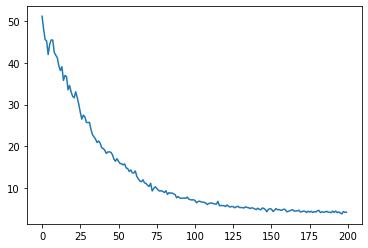

In [9]:
plt.plot(np.arange(len(o_losses)), o_losses)
plt.show()

Loss:  3.7751386165618896


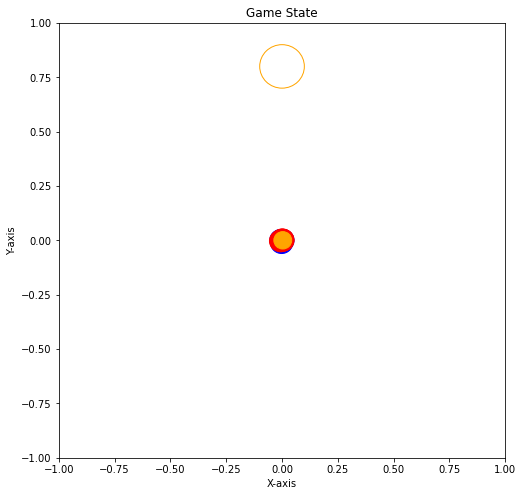

In [10]:
init_game_state = random_initial_game_state(batch_size=1)
all_game_states = run_simulation(o_model, d_model, init_game_state)

print('Loss: ', loss_function(all_game_states).item())
show_game_state(all_game_states[-1][0])
plt.show()

# Loss Function Visuals

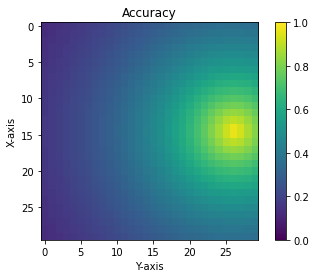

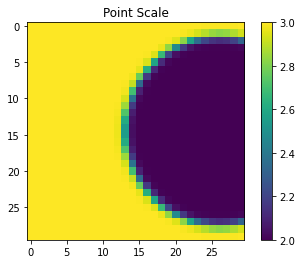

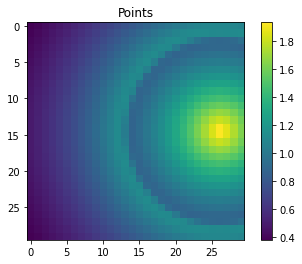

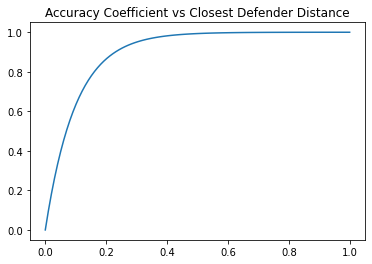

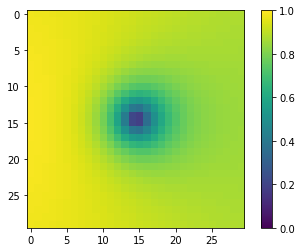

In [11]:
resolution = 30

x, y = torch.meshgrid(torch.linspace(-1, 1, resolution), torch.linspace(-1,1, resolution))
r = torch.sqrt((x-hoop_location[0])**2+(y-hoop_location[1])**2)
ri = 1/torch.exp(r)
theta = torch.atan2(y, x)



# plt.imshow(np.log(ri), cmap='gray')
# plt.show()

accuracy = ri
plt.imshow(accuracy, vmin=0, vmax=1)
plt.xlabel('Y-axis')
plt.ylabel('X-axis')
plt.title('Accuracy')
plt.colorbar()
plt.show()

point_scale = 2*torch.ones((resolution, resolution)) + 1 / (1 + torch.exp(-50 * (r-0.9)))

plt.imshow(point_scale)
plt.title('Point Scale')
plt.colorbar()
plt.show()


plt.imshow(point_scale*accuracy)
plt.title('Points')
plt.colorbar()
plt.show()


d = torch.linspace(0, 1, 100)
contest = 1 - torch.exp(-10*d)
plt.plot(d, contest)
plt.title('Accuracy Coefficient vs Closest Defender Distance')
plt.show()



r = torch.sqrt((x)**2+(y)**2)
contest = 1 - torch.exp(-5*r)

direction = (torch.cos(theta+0.5*np.pi)+13.)/14.

plt.imshow(direction*contest, vmin=0, vmax=1)
plt.colorbar()
plt.show()


